<b>ML problem:</b> Binary Classification <br>
<b>Task:</b> Identify the probability of a lead getting converted to sales

### Import dependencies

In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import models
from keras import layers

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split




### Load data from an excel file into a Pandas DataFrame

In [3]:
df = pd.read_excel(input_dir + filename)

## Exploratory Data Analysis

In [4]:
print('Dataset shape: ', df.shape)
print('Features: ', df.columns)
df.head(2)

Dataset shape:  (357970, 9)
Features:  Index(['id', 'Gender', 'Age', 'Area code', 'Have hearing aid',
       'Hearing aid age', 'Have ENT prescription', 'Distance to store (in km)',
       'Sales'],
      dtype='object')


,id,Gender,Age,Area code,Have hearing aid,Hearing aid age,Have ENT prescription,Distance to store (in km),Sales
0,167647,Male,48,7.0,0.0,< 1 Year,No,25.0,0
1,17163,Male,32,28.0,0.0,1-2 Year,Yes,32.0,0




1.   The dataset consists of 357970 records.
2.   There are 8 features and 1 binary target. 



In [5]:
df.describe()

,id,Age,Area code,Have hearing aid,Distance to store (in km),Sales
count,357970.000000,357970.000000,357947.000000,357465.000000,357945.000000,357970.000000
mean,230874.387809,41.178079,26.381671,0.553386,35.007842,0.027041
std,137869.896274,8.340704,13.290270,0.497142,6.054417,0.162204
min,3.000000,30.000000,0.000000,0.000000,20.000000,0.000000
25%,113167.250000,35.000000,15.000000,0.000000,30.000000,0.000000
50%,226595.500000,41.000000,28.000000,1.000000,35.000000,0.000000
75%,339778.500000,46.000000,35.000000,1.000000,40.000000,0.000000
max,508145.000000,85.000000,52.000000,1.000000,45.000000,1.000000


Let's take a look at the number of unique values. 

In [6]:
df.nunique()

id                           357970
Gender                            2
Age                              56
Area code                        53
Have hearing aid                  2
Hearing aid age                   5
Have ENT prescription             2
Distance to store (in km)        26
Sales                             2
dtype: int64

### Data Visualization

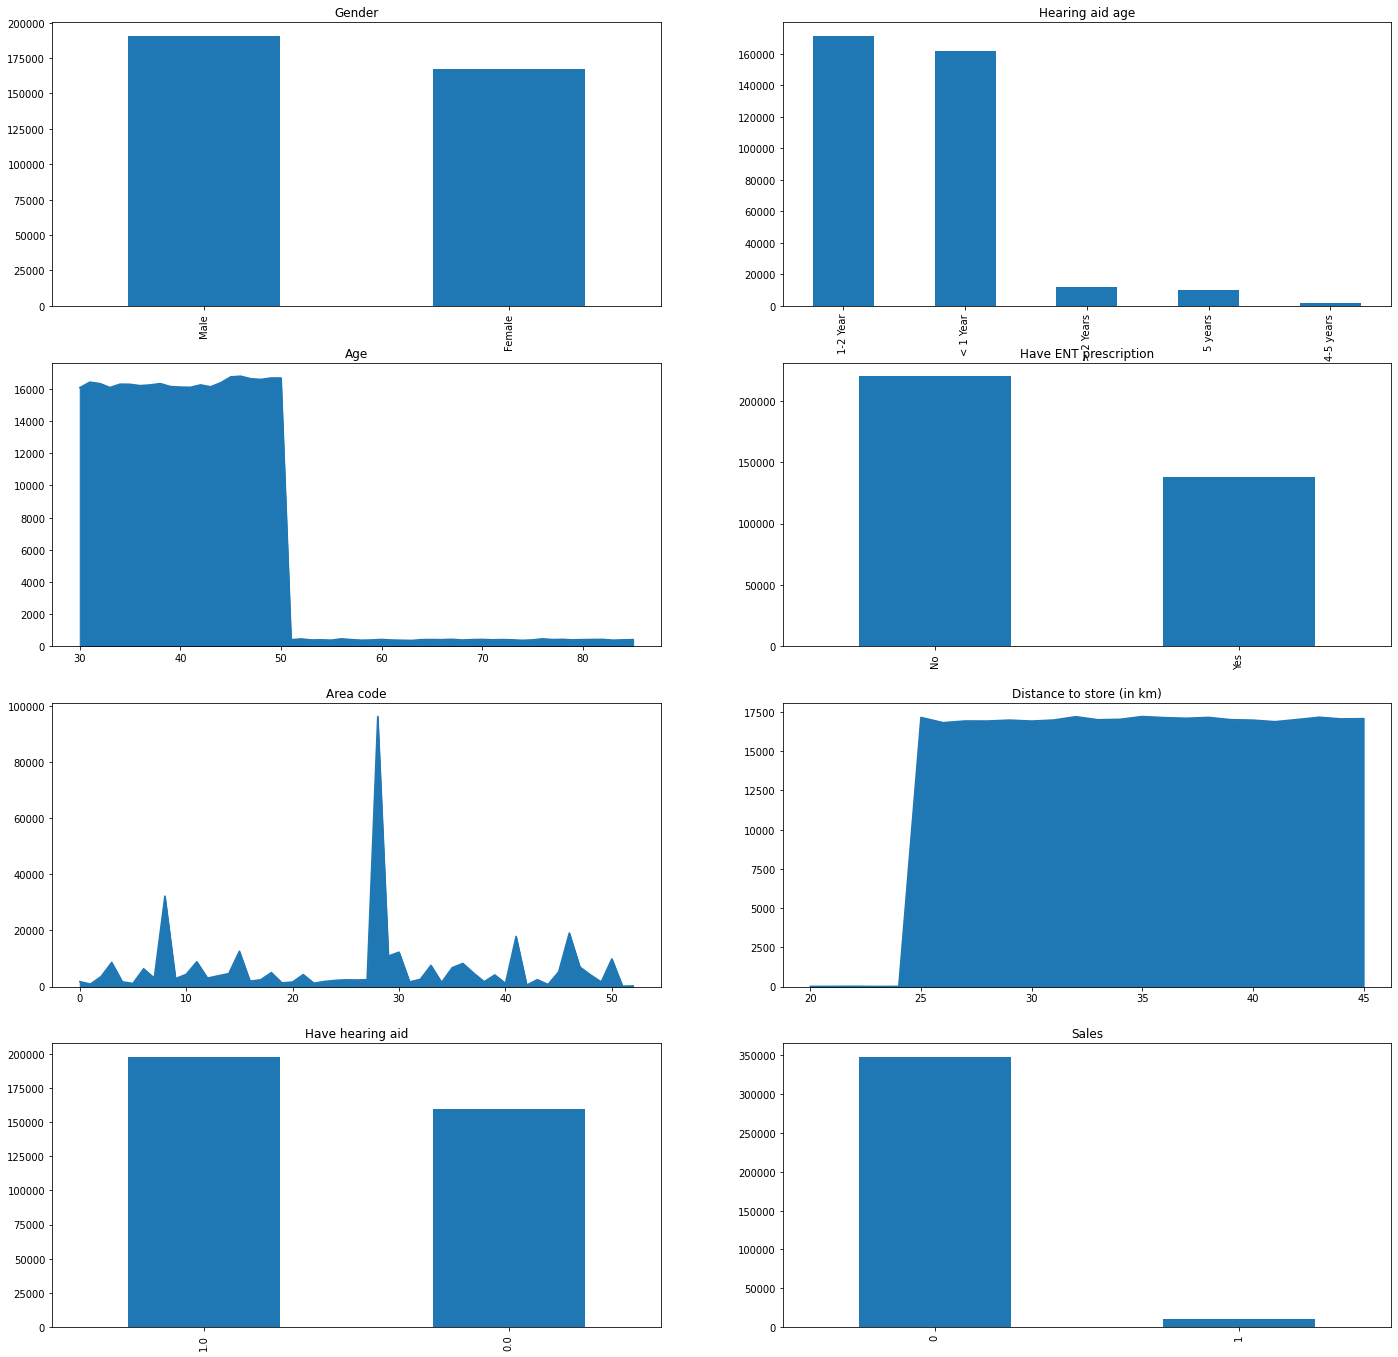

In [7]:
fig, axs=plt.subplots(4,2,figsize=(24,24))

df['Gender'].value_counts().plot.bar(ax=axs[0][0], title= 'Gender')
df['Age'].value_counts().sort_index().plot.area(ax=axs[1][0], title= 'Age')
df['Area code'].value_counts().sort_index().plot.area(ax=axs[2][0], title= 'Area code')
df['Have hearing aid'].value_counts().plot.bar(ax=axs[3][0], title= 'Have hearing aid')
df['Hearing aid age'].value_counts().plot.bar(ax=axs[0][1], title= 'Hearing aid age')
df['Have ENT prescription'].value_counts().plot.bar(ax=axs[1][1], title= 'Have ENT prescription')
df['Distance to store (in km)'].value_counts().sort_index().plot.area(ax=axs[2][1], title= 'Distance to store (in km)')
df['Sales'].value_counts().plot.bar(ax=axs[3][1], title= 'Sales')

(These three cells are for the inferences below)

In [8]:
df[df['Age'] <= 50 ]['Age'].count() / df['Age'].count()

0.9599268095091767

In [9]:
df[df['Hearing aid age'].isin(['< 1 Year', '1-2 Year'])]['Hearing aid age'].count() / df['Hearing aid age'].count()

0.9330435488430545

In [10]:
df[df['Have hearing aid'] == 0]['Have hearing aid'].count() / df['Have hearing aid'].count()

0.4466143538528248

Inferences:



*   The age of the majority of potential customers (96%) is in the range of 30 to 50. Maybe this is a consequence of the chosen target strategy.
*   Only 7% of prospects have a hearing aid older than 2 years.
*   Quite a lot of people (45%) do not have a hearing aid.
*   A sharp increase in potential customers starting from a distance of 25 km.
*   The classes are pretty imbalanced.
*   It's nothing to say regarding area codes from this visualization. 

It makes sense to look at the correlations, i.e. at linear relationships of the parameters on each other. It is especially interesting to see how sales depend on chosen features.



Before moving forward, let's check the NaN values in the dataset and replace them.

In [11]:
df_cln = df.copy()
df_cln.isnull().sum()

id                             0
Gender                         0
Age                            0
Area code                     23
Have hearing aid             505
Hearing aid age              693
Have ENT prescription          0
Distance to store (in km)     25
Sales                          0
dtype: int64

Replace missing values:

Nan values are encoded as 'Unknown' for categorical variables, i.e. introduce one more option. Of course, there are techniques to replace nan with mode, median, etc. So, I'm leaving space for experiments, improvement.

1.   Have hearing aid: NaN -> 'Unknown'
2.   Hearing aid age: NaN -> 'Unknown'
3.   Distance to store (in km) -> 0. 0 is a default value and it's vacant. There are no prospects who live in a store.
4. Area code -> remove. Again, It's feasible to use median or '-1' (because '0' is already some area). But since there are only 23 records with NaN, the rows are just erased. 



In [12]:
# there are only records with 'negative' output 
df_cln[df_cln['Area code'].isnull()]['Sales'].unique()

array([0])

In [13]:
nan_replace = {'Have hearing aid': 'Unknown', 'Hearing aid age': 'Unknown', "Distance to store (in km)": .0}

# remove 'Area code' NaNs
df_cln.drop(df_cln[df_cln['Area code'].isnull()].index, inplace=True)

df_cln = df_cln.fillna(nan_replace)

In [14]:
# Recheck missing values

df_cln.isnull().sum()

id                           0
Gender                       0
Age                          0
Area code                    0
Have hearing aid             0
Hearing aid age              0
Have ENT prescription        0
Distance to store (in km)    0
Sales                        0
dtype: int64

In [15]:
# explicitly specify the string type otherwise, it causes issues

df_cln['Have hearing aid'] = df_cln['Have hearing aid'].astype('string')

### Correlation matrix

In [16]:
# remove ID column, because it isn't a feature for the task, and it isn't used for training

df_cln = df_cln.iloc[:,1:]

In [17]:
df_cln.head(2)

,Gender,Age,Area code,Have hearing aid,Hearing aid age,Have ENT prescription,Distance to store (in km),Sales
0,Male,48,7.0,0.0,< 1 Year,No,25.0,0
1,Male,32,28.0,0.0,1-2 Year,Yes,32.0,0


In [18]:
# encode categorical variables by using LabelEncoder()

label_encoder = LabelEncoder()
df_cln['Gender'] = label_encoder.fit_transform(df_cln['Gender']).astype('float64')
df_cln['Have hearing aid'] = label_encoder.fit_transform(df_cln['Have hearing aid']).astype('float64')
df_cln['Hearing aid age'] = label_encoder.fit_transform(df_cln['Hearing aid age']).astype('float64')
df_cln['Have ENT prescription'] = label_encoder.fit_transform(df_cln['Have ENT prescription']).astype('float64')

In [19]:
# set a type of variables
df_cln = df_cln.astype('float64')
df_cln.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357947 entries, 0 to 357969
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Gender                     357947 non-null  float64
 1   Age                        357947 non-null  float64
 2   Area code                  357947 non-null  float64
 3   Have hearing aid           357947 non-null  float64
 4   Hearing aid age            357947 non-null  float64
 5   Have ENT prescription      357947 non-null  float64
 6   Distance to store (in km)  357947 non-null  float64
 7   Sales                      357947 non-null  float64
dtypes: float64(8)
memory usage: 24.6 MB


In [20]:
corr = df_cln.corr()
corr

,Gender,Age,Area code,Have hearing aid,Hearing aid age,Have ENT prescription,Distance to store (in km),Sales
Gender,1.000000,0.021406,0.002351,-0.075389,-0.140060,0.079637,0.002709,0.026261
Age,0.021406,1.000000,0.005493,0.061310,0.012694,0.172947,-0.000629,0.473926
Area code,0.002351,0.005493,1.000000,-0.019963,-0.035883,0.023132,0.000212,0.006343
Have hearing aid,-0.075389,0.061310,-0.019963,1.000000,0.246971,-0.639211,-0.001099,0.135583
Hearing aid age,-0.140060,0.012694,-0.035883,0.246971,1.000000,-0.178099,-0.001269,0.062214
Have ENT prescription,0.079637,0.172947,0.023132,-0.639211,-0.178099,1.000000,0.004169,0.206458
Distance to store (in km),0.002709,-0.000629,0.000212,-0.001099,-0.001269,0.004169,1.000000,-0.000779
Sales,0.026261,0.473926,0.006343,0.135583,0.062214,0.206458,-0.000779,1.000000


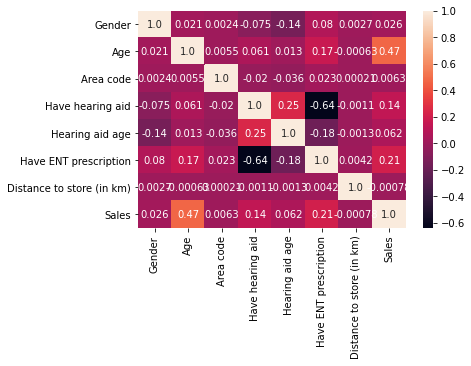

In [21]:
sns.heatmap(corr, annot=True, fmt='.2')

Inferences:

*   Customers with a prescription are more likely to buy a product.
*   The age factor is very significant (0.47) for making a purchase.
*   The relation between 'have hearing aid' and 'have ENT prescription' is pretty strong.



### Train test split

In [22]:
X = df_cln.iloc[:,:-1]
y = df_cln.iloc[:,-1]
# y = df_cln.iloc[:,-1].astype('int64')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Normalizing the data

It would be problematic to work further with values that all take different ranges. The model could adapt to such heterogeneous data, but it would make learning more difficult. For this reason, normalization is used.

In [24]:
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std


X_test -= mean
X_test /= std

In [25]:
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(286357, 7)

(71590, 7)

(286357,)

(71590,)

# Training

Two different models are considered. Random Forest is chosen because of the opportunity to interpret the results, which is very important for business. The second model is a simple dense neural network.

## Random Forest Classifier

In [26]:
forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [28]:
# predict Sales on test set
y_pred = forest_model.predict(X_test)

### Evaluation

In [29]:
print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score : 0.9931


For imbalance data, the accuracy metric shows a skewed view of the model's performance. That's why let's focus on the f1-score.

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     69610
         1.0       0.85      0.91      0.88      1980

    accuracy                           0.99     71590
   macro avg       0.92      0.95      0.94     71590
weighted avg       0.99      0.99      0.99     71590



The Sale class 0 is predicted better. Nevertheless, the weighted f1 score is still high and equal 0.99.

### Feature Importance

Feature importance gives us an idea of the problem by telling which variables are most distinguishable between classes. For example, the Age is indicating whether the potential customer is going to buy a product.
That can also be used for feature engineering by creating new features from the most important ones. Feature importance is also used for selecting features or removing them with low importance. For example, it turned out that 'Have ENT prescription' and 'Gender' have the lowest impact on customer's decisions.

In [31]:
fi = pd.DataFrame({'feature': list(df_cln.iloc[:,:-1].columns),
                   'importance': forest_model.feature_importances_}).\
                    sort_values('importance', ascending = False)

fi

,feature,importance
1,Age,0.438295
4,Hearing aid age,0.333600
3,Have hearing aid,0.104109
6,Distance to store (in km),0.048257
2,Area code,0.044995
5,Have ENT prescription,0.027359
0,Gender,0.003385


## Neural Network

The Random Forest Classifier is used to interpret the results, which is very helpful for business. But let's also play around with a Dense Neural network (DNN). DNN can potentially demonstrate even better performance, but the obstacle for business is NN's mechanism of decision making.

Keras is used as a Deep Learning framework.

In [37]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[keras.metrics.BinaryAccuracy()])

In [39]:
history = model.fit(X_train,
          y_train,
          epochs=20,
          batch_size=256,
          validation_split=0.2)

Epoch 1/20
895/895 [==============================] - 16s 3ms/step - loss: 0.1354 - binary_accuracy: 0.9498 - val_loss: 0.0283 - val_binary_accuracy: 0.9892
Epoch 2/20
895/895 [==============================] - 2s 2ms/step - loss: 0.0276 - binary_accuracy: 0.9894 - val_loss: 0.0259 - val_binary_accuracy: 0.9915
Epoch 3/20
895/895 [==============================] - 2s 2ms/step - loss: 0.0272 - binary_accuracy: 0.9909 - val_loss: 0.0241 - val_binary_accuracy: 0.9925
Epoch 4/20
895/895 [==============================] - 2s 2ms/step - loss: 0.0242 - binary_accuracy: 0.9924 - val_loss: 0.0219 - val_binary_accuracy: 0.9931
Epoch 5/20
895/895 [==============================] - 2s 2ms/step - loss: 0.0214 - binary_accuracy: 0.9932 - val_loss: 0.0195 - val_binary_accuracy: 0.9934
Epoch 6/20
895/895 [==============================] - 2s 2ms/step - loss: 0.0194 - binary_accuracy: 0.9935 - val_loss: 0.0182 - val_binary_accuracy: 0.9939
Epoch 7/20
895/895 [==============================] - 2s 2ms/st

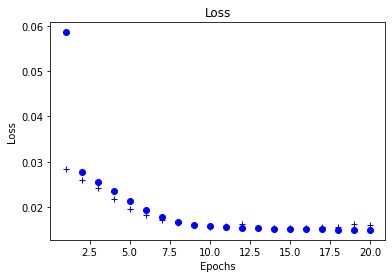

In [40]:
history_dict = history.history
history_dict.keys()

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo')
# b+ is for "blue crosses"
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

Thus, the overfitting problem is not faced and the values of the loss are gradually decreasing, both for validation and for train.

### Evaluation

In [41]:
y_pred = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     69610
         1.0       0.84      0.96      0.90      1980

    accuracy                           0.99     71590
   macro avg       0.92      0.98      0.95     71590
weighted avg       0.99      0.99      0.99     71590



Again, the classification report shows that Sale class 0 is predicted more accurate, but the weighted f1 score is pretty high and equals 0.99.

## Conclusion



A high f1 score (0.99) is obtained for both models. Random Forest is prefered, but at the same time, selecting the most tuned hyperparameters of a NN can make it more reliable. Prospective: the techniques to eliminate the class imbalance or data imputation for predicting missing values. 